In [ ]:
%pip install transformers sentence-transformers

In [2]:
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer,AutoTokenizer, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import datetime
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

/home/mijanur/Desktop/AI/DL NLP/natural_language_processing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-25 07:24:57.397379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 07:25:07.476730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving text.jpg to text.jpg


### OCR (Optical Character Recognition)

In [ ]:
%pip install google-cloud-vision

#### Getting Handwritten Text

In [ ]:
import os, io
from google.cloud import vision

## Showing the imported Image

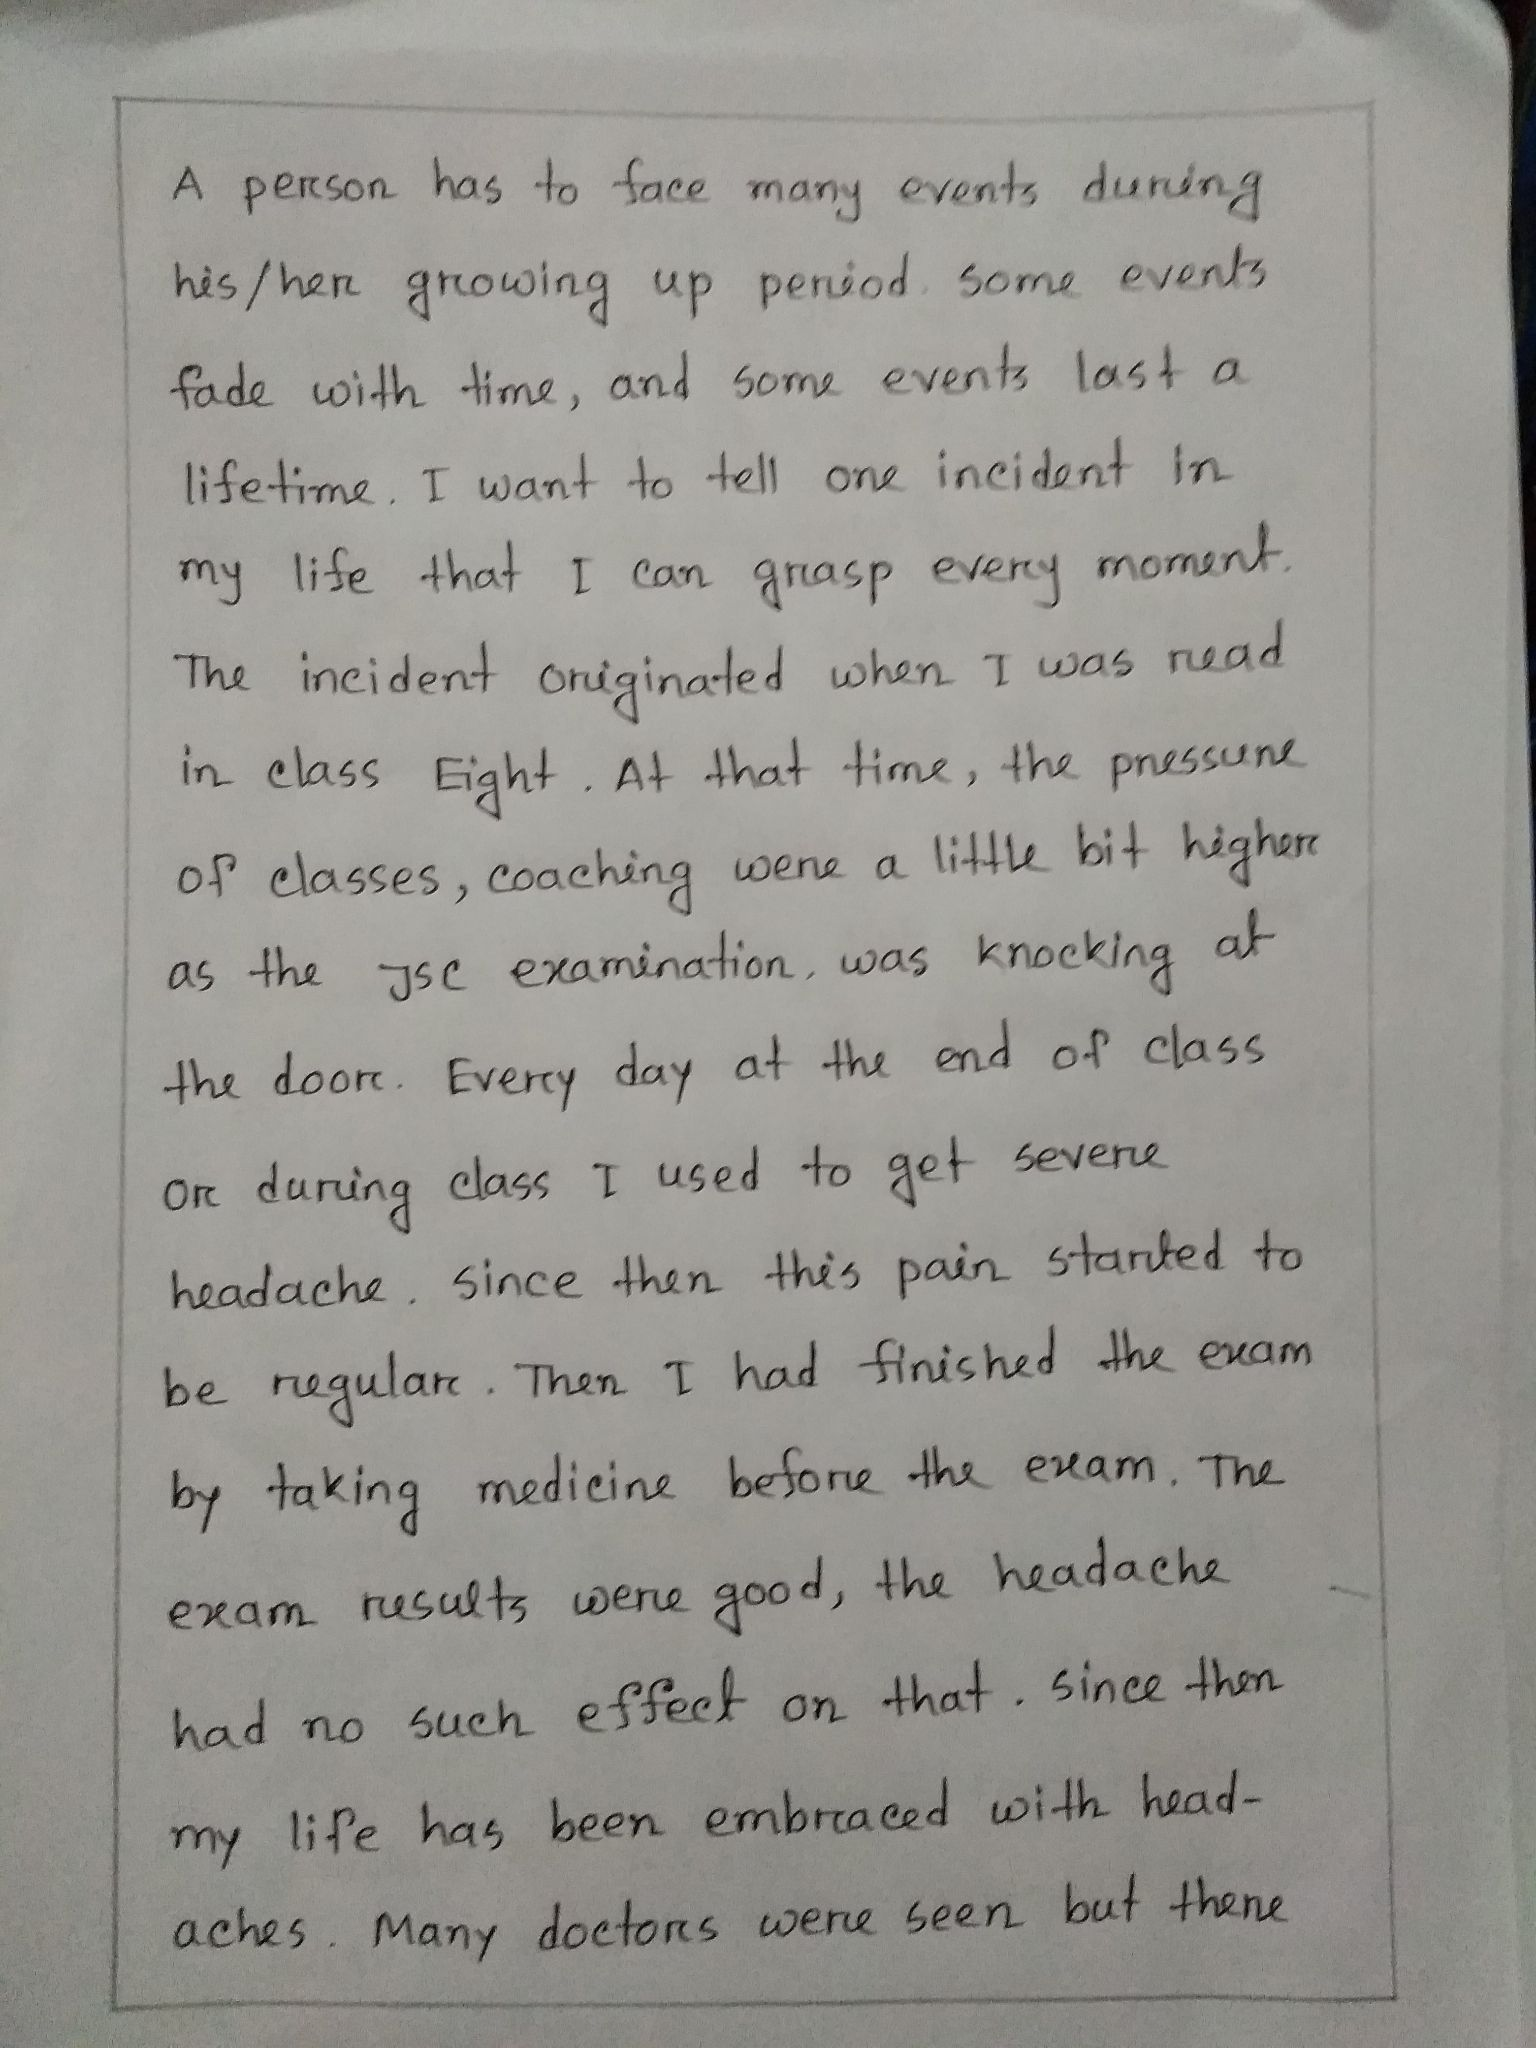

In [ ]:
from IPython.display import Image
Image("text.jpg")

#### API Credentials

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"examsystem_ocr_cloud_vision.json"

In [ ]:
# initiate a client
client = vision.ImageAnnotatorClient()

In [ ]:
# load image into memory
with io.open("text.jpg","rb") as image_file:
    file_content = image_file.read()

In [ ]:
# perform text detection from the image
image_detail = vision.Image(content=file_content)
response = client.document_text_detection(image=image_detail)

#### Output

In [ ]:
# print text from the dcoment
student_answer_text = response.full_text_annotation.text

# remove extra spaces
student_answer_text.replace("\n"," ")

'A person has to face many events during his/her growing up peniod. Some events fade with time, and some events last a lifetime. I want to tell one incident in as the my life that I can grasp every moment. The incident originated when I was read in class Eight. At that time, the pressure of classes, coaching wene a little bit higher at Jsc examination, was knocking the door. Every day at the end of class Or during class I used to get severe headache. Since then this pain started to be regular. Then I had finished the exam by taking medicine before the exam. The exam results were good, the headache had no such effect on that. Since then my life has been embraced with head- aches. Many doctors were seen but there'

In [ ]:
len(student_answer_text.split())

135

## Data Preprocessing (Stop Words,Remove Punctuation and Grammmar Check etc)

1. Removing stop words (which are considered as noise in conventional text representation like bag-of-words or tf-idf) can and probably will worsen the predictions of your BERT model.
2. Preprocessing is not needed when using pre-trained language representation models like BERT. It uses all of the information in a sentence, punctuation and stop-words from a wide range of perspectives by leveraging a multi-head self attention mechanism.

## Summarization

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline

In [ ]:
#model and tokenizer loading
# LLM is a custom model trained on the LaMini dataset. It is a T5 model trained on the summarization task.
# LLM full name is LaMini Language Model. La Mini is a french dataset for summarization.
checkpoint = "MBZUAI/LaMini-Flan-T5-248M"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
base_model = T5ForConditionalGeneration.from_pretrained(checkpoint, device_map='auto', torch_dtype=torch.float32)

In [ ]:
#LLM pipeline
def llm_pipeline(input_text):
    pipe_sum = pipeline(
        'summarization',
        model = base_model,
        tokenizer = tokenizer,
        max_length = 500,
        min_length = 50)
    result = pipe_sum(input_text)
    result = result[0]['summary_text']

    return result

In [ ]:
text = """
With the national polls around six months away, the Awami League and the BNP are going to hold programmes and counter-programmes today and tomorrow to show off their strength on the streets.

The BNP will today march from Gabtoli to Jatrabari from 10:00am to 4:00pm in the capital and bring out processions in other cities and districts to realise its one-point demand for polls under a non-party interim government.

Sources in the BNP said instructions were given to all Dhaka north and South city units to ensure huge gatherings.

To counter BNP's programme, ruling Awami league will bring out what it termed "a march for peace and development" in the capital.

At 3:00pm today, Dhaka city (South) AL will bring out a procession from Institution of Engineers, Bangladesh, that will end at Dhanmondi 32. AL General Secretary Obaidul Quader will join the programme.

The unit is planning to gather over a lakh people in the event.
"""

In [ ]:
summary = llm_pipeline(text)

## Answer Evaluation

#### Load Dataset

In [ ]:
# Load your dataset into a Pandas DataFrame
df = pd.read_csv('mohler_dataset.csv')
# df = pd.read_csv('dataset.csv')

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
# Instantiate the BERT tokenizer
# You can use larger variants of the model, here we're using the base model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
class BDataset():
    def __init__(self, dataset):
        # Normalize the similarity scores in the dataset
        similarity_scores = dataset['score_avg']
        self.normalized_similarity_scores = [i/5.0 for i in similarity_scores]
        self.first_sentences = dataset['desired_answer']
        self.second_sentences = dataset['student_answer']
        self.concatenated_sentences = [[str(x), str(y)] for x,y in zip(self.first_sentences, self.second_sentences)]

    def __len__(self):
        return len(self.concatenated_sentences)

    def get_batch_labels(self, idx):
        return torch.tensor(self.normalized_similarity_scores[idx])

    def get_batch_texts(self, idx):
        return tokenizer(self.concatenated_sentences[idx], padding='max_length', max_length= 128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


def collate_fn(texts):
    input_ids = texts['input_ids']
    attention_masks = texts['attention_mask']
    features = [{'input_ids': input_id, 'attention_mask': attention_mask}
                for input_id, attention_mask in zip(input_ids, attention_masks)]
    return features

In [ ]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
train_ds = BDataset(train_df)
val_ds = BDataset(val_df)
test_ds = BDataset(test_df)

train_size = len(train_ds)
val_size = len(val_ds)
test_size = len(test_ds)

print('Training samples : {} '.format(train_size))
print('Test samples : {} '.format(test_size))
print('Validation samples : {} '.format(val_size))

Training samples : 10 
Test samples : 3 
Validation samples : 2 


In [4]:
# config = BertConfig.from_pretrained('bert-base-uncased')
# config.hidden_size = 768

# model = BertModel(config)

# sentence-transformers/all-MiniLM-L6-v2
# max_seq_length=512 or 128
# bert-base-uncased

class Bert(torch.nn.Module):
    def __init__(self):
        super(Bert, self).__init__()
        self.bert = models.Transformer('sentence-transformers/all-MiniLM-L6-v2', max_seq_length=128)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [7]:
# Instantiate the model and move it to GPU
model = Bert()
model.to(device)

Bert(
  (bert): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_layer): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (sts_bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
)

In [8]:
class CosineSimilarityLoss(torch.nn.Module):
  # L1Loss : it means the MAELoss()
    def __init__(self,  loss_fn=torch.nn.MSELoss(), transform_fn=torch.nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fn = loss_fn
        self.transform_fn = transform_fn
        self.cos_similarity = torch.nn.CosineSimilarity(dim=1)

    def forward(self, inputs, labels):
        emb_1 = torch.stack([inp[0] for inp in inputs])
        emb_2 = torch.stack([inp[1] for inp in inputs])
        outputs = self.transform_fn(self.cos_similarity(emb_1, emb_2))
        return self.loss_fn(outputs, labels.squeeze())

In [ ]:
batch_size = 8
num_workers = 4

train_dataloader = DataLoader(
            train_ds,  # The training samples.
            num_workers =num_workers,
            batch_size = batch_size, # Use this batch size.
            shuffle=True # Select samples randomly for each batch
        )
test_dataloader = DataLoader(
            test_ds,
            num_workers = num_workers,
            batch_size = batch_size # Use the same batch size
        )

validation_dataloader = DataLoader(
            val_ds,
            num_workers = num_workers,
            batch_size = batch_size # Use the same batch size
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
optimizer = AdamW(model.parameters(), lr = 1e-6)

In [ ]:
# total number of epochs
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def train():
  seed_val = 42
  criterion = CosineSimilarityLoss()
  criterion = criterion.to(device)

  random.seed(seed_val)
  torch.manual_seed(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  for epoch_i in range(0, epochs):

      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for train_data, train_label in tqdm(train_dataloader):

          train_data['input_ids'] = train_data['input_ids'].to(device)
          train_data['attention_mask'] = train_data['attention_mask'].to(device)

          train_data = collate_fn(train_data)
          model.zero_grad()

          output = [model(feature) for feature in train_data]

          loss = criterion(output, train_label.to(device))
          total_train_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()


      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      print("Average training loss: {0:.5f}".format(avg_train_loss))
      print("Running Validation...")

      model.eval()

      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for val_data, val_label in tqdm(validation_dataloader):

          val_data['input_ids'] = val_data['input_ids'].to(device)
          val_data['attention_mask'] = val_data['attention_mask'].to(device)

          val_data = collate_fn(val_data)

          with torch.no_grad():
              output = [model(feature) for feature in val_data]

          loss = criterion(output, val_label.to(device))
          total_eval_loss += loss.item()

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      print("\nValidation Loss: {0:.5f}".format(avg_val_loss))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'train_loss': avg_train_loss,
              'valid_loss': avg_val_loss,
          }
      )

  print("Training complete!")

  return model, training_stats

In [ ]:
# training and validation together
model, training_stats = train()

======== Epoch 1 / 5 ========
Training...


100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


Average training loss: 0.09365
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



Validation Loss: 0.14644
======== Epoch 2 / 5 ========
Training...


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Average training loss: 0.08797
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



Validation Loss: 0.14573
======== Epoch 3 / 5 ========
Training...


100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Average training loss: 0.11049
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



Validation Loss: 0.14506
======== Epoch 4 / 5 ========
Training...


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Average training loss: 0.13828
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Validation Loss: 0.14467
======== Epoch 5 / 5 ========
Training...


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Average training loss: 0.06974
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Validation Loss: 0.14452
Training complete!


In [ ]:
training_stats

[{'epoch': 1,
  'train_loss': 0.09365078806877136,
  'valid_loss': 0.1464398056268692},
 {'epoch': 2,
  'train_loss': 0.08797385916113853,
  'valid_loss': 0.14572608470916748},
 {'epoch': 3,
  'train_loss': 0.11048555001616478,
  'valid_loss': 0.14506377279758453},
 {'epoch': 4,
  'train_loss': 0.1382838562130928,
  'valid_loss': 0.14466719329357147},
 {'epoch': 5,
  'train_loss': 0.06973941251635551,
  'valid_loss': 0.14451943337917328}]

In [ ]:
seed_val = 42
criterion = CosineSimilarityLoss()
criterion = criterion.to(device)

random.seed(seed_val)
torch.manual_seed(seed_val)

### Training, Validation and Testing in seperated function

In [ ]:
# training and calculating training loss
def train():
  model.train()
  all_avg_train_loss = []

  for epoch_i in range(0, epochs):
    total_train_loss = 0

    # For each batch of training data...
    for train_data, train_label in tqdm(train_dataloader):

        train_data['input_ids'] = train_data['input_ids'].to(device)
        train_data['attention_mask'] = train_data['attention_mask'].to(device)

        train_data = collate_fn(train_data)
        model.zero_grad()

        output = [model(feature) for feature in train_data]

        loss = criterion(output, train_label.to(device))
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average training loss: {0:.5f}".format(avg_train_loss))

    all_avg_train_loss.append(avg_train_loss)

  return all_avg_train_loss

In [ ]:
# calculte MAE for test set

def test():
  model.eval()
  all_avg_test_loss = []

  for epoch_i in range(0, epochs):
    total_test_loss = 0
    nb_test_steps = 0

    for test_data, test_label in tqdm(test_dataloader):

        test_data['input_ids'] = test_data['input_ids'].to(device)
        test_data['attention_mask'] = test_data['attention_mask'].to(device)

        test_data = collate_fn(test_data)

        with torch.no_grad():
            output = [model(feature) for feature in test_data]

        loss = criterion(output, test_label.to(device))
        total_test_loss += loss.item()

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    print("Average testing loss: {0:.5f}".format(avg_test_loss))

    all_avg_test_loss.append(avg_test_loss)

  return all_avg_test_loss



In [ ]:
def validation():
  model.eval()
  all_avg_val_loss = []

  for epoch_i in range(0, epochs):
    total_eval_loss = 0

    # Evaluate data for one epoch
    for val_data, val_label in tqdm(validation_dataloader):

      val_data['input_ids'] = val_data['input_ids'].to(device)
      val_data['attention_mask'] = val_data['attention_mask'].to(device)

      val_data = collate_fn(val_data)

      with torch.no_grad():
          output = [model(feature) for feature in val_data]

      loss = criterion(output, val_label.to(device))
      total_eval_loss += loss.item()

    # Calculate the average loss over all of the batches.
    avg_val_loss =  total_eval_loss / len(validation_dataloader)
    print("Validation Loss: {0:.5f}".format(avg_val_loss))

    all_avg_val_loss.append(avg_val_loss)

  return all_avg_val_loss

In [ ]:
avg_train_losses = train()

100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Average training loss: 0.08318


100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


Average training loss: 0.04443


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

Average training loss: 0.07088


In [ ]:
avg_train_losses

[0.083177974447608, 0.04443281888961792, 0.07087570242583752]

In [ ]:
avg_val_losses = validation()

In [ ]:
avg_tes_losses = test()

#### Training stats for seperated train, test, validattion function

In [ ]:
# Storing a number of quantities such as training and validation loss,
training_stats = []

# Record all statistics from this epoch.
for epoch_i in range(0, epochs):
  training_stats.append(
      {
          'epoch': epoch_i,
          'train_loss': avg_train_losses[epoch_i],
          'valid_loss':  avg_val_losses[epoch_i],
      }
  )

In [ ]:
train_losses = []
valid_losses = []

for i in range(len(training_stats)):
    train_losses.append(training_stats[i]['train_loss'])
    valid_losses.append(training_stats[i]['valid_loss'])

#### DataFrame from training statistics

In [ ]:
# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display the table
df_stats

,train_loss,valid_loss
epoch,,
1,0.093651,0.146440
2,0.087974,0.145726
3,0.110486,0.145064
4,0.138284,0.144667
5,0.069739,0.144519


#### Plotting graph for combined train and validation losses

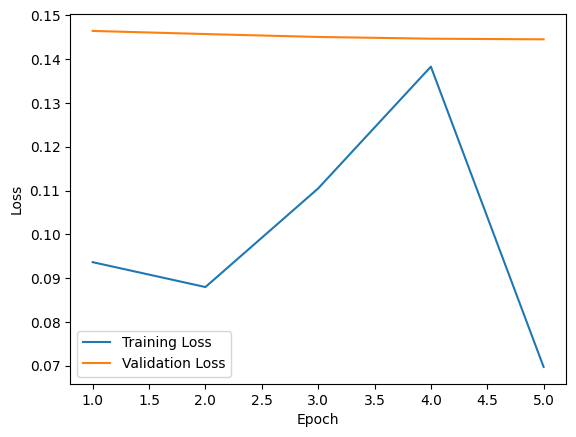

In [ ]:
# Plot the loss values
all_epochs = range(1, epochs + 1)
plt.plot(all_epochs, train_losses, label='Training Loss')
plt.plot(all_epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plotting graph for seperated train and validation losses

In [ ]:
# Plot the loss values
all_epochs = range(1, epochs + 1)
plt.plot(all_epochs, avg_train_losses, label='Training Loss')
plt.plot(all_epochs, avg_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicting the cosine similarity

In [9]:
model.eval()

def predict_similarity(sentence_pair):
  test_input = tokenizer(sentence_pair, padding='max_length', max_length = 128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']
  output = model(test_input)
  similarity = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()

  return similarity

### Demo Testing Data

In [ ]:
nlp_defination = "Natural language processing (NLP) is a branch of artificial intelligence (AI) that enables computers to comprehend, generate, and manipulate human language. Natural language processing has the ability to interrogate the data with natural language text or voice"

In [ ]:
applications_of_nlp = """
Sentiment analysis is a popular application of Natural Language Processing (NLP) that involves determining the sentiment or emotional tone of a piece of text, such as a review, social media post, or customer feedback. The goal is to classify the text as positive, negative, or neutral based on the underlying sentiment expressed.
Grammar check using NLP is the process of automatically identifying and correcting grammatical errors in a given piece of text. While achieving human-level grammar checking is challenging, NLP techniques can help in detecting common grammatical mistakes and suggesting potential corrections.
Email classification using NLP is the process of automatically categorizing emails into predefined classes or categories based on their content. This is a common application of NLP and machine learning in email management systems, spam filtering, customer support, and more.
"""

In [ ]:
text1 = """
Gradient descent is an optimization algorithm which is commonly-used to train machine learning models and neural networks. Training data helps these models learn over time, and the cost function within gradient descent specifically acts as a barometer, gauging its accuracy with each iteration of parameter updates.
"""
text2 = """
Gradient descent (GD) is an iterative first-order optimisation algorithm used to find a local minimum/maximum of a given function. This method is commonly used in machine learning (ML) and deep learning(DL) to minimise a cost/loss function (e.g. in a linear regression). Due to its importance and ease of implementation, this algorithm is usually taught at the beginning of almost all machine learning courses.
"""
text3 = """
Artificial intelligence is the simulation of human intelligence processes by machines, especially computer systems. Specific applications of AI include expert systems, natural language processing, speech recognition and machine vision.
"""

text4 = """
Natural language processing (NLP) is a branch of artificial intelligence (AI) that enables computers to comprehend, generate, and manipulate human language. Natural language processing has the ability to interrogate the data with natural language text or voice.
"""

text5 = """
Gradient Descent is known as one of the most commonly used optimization algorithms to train machine learning models by means of minimizing errors between actual and expected results. Further, gradient descent is also used to train Neural Networks.

In mathematical terminology, Optimization algorithm refers to the task of minimizing/maximizing an objective function f(x) parameterized by x. Similarly, in machine learning, optimization is the task of minimizing the cost function parameterized by the model's parameters. The main objective of gradient descent is to minimize the convex function using iteration of parameter updates. Once these machine learning models are optimized, these models can be used as powerful tools for Artificial Intelligence and various computer science applications.
"""

# This is the summerized version of text5
text6 = """
 Gradient Descent is an optimization algorithm used to train machine learning models by minimizing errors between actual and expected results. It is also used to train Neural Networks and minimize the cost function parameterized by the model's parameters.
"""

text7 = """
The Fear Nothing Blood Test is able to give you an accurate understanding of your health by checking several key health indicators. The standard Fear Nothing Blood Test can tell you about your: Vitamin levels. Hormone levels. Liver health.
"""

text8 = """
This subject only gives a brief description about different types of materials used in building construction for members like foundation, masonry, arches, lintels, balcony, roof, floor, doors, windows, stairs, plastering, painting and other general topics. Properties of various construction materials, their uses and different applications are discussed in this subject.
"""

text9="""
Initial setting time for ideal cement mix is around 30 minutes for almost all kind of cements. For masonry cement it can be 90 minutes. Final setting time of ideal cement mix should be 10 hours at max. For masonry cement it shouldn’t exceed 24 hours.
"""

t1 = 'A man is playing a large flute.'
t2 = 'A man is playing a flute.'

In [18]:
d1 = "Taking one array element at a time, from left to right, it inserts it in the right position among the already sorted elements on its left."
d2 = "Every iteration of an insertion sort takes away an element from the input data, inserting it at the right position in the sorted list."

### Predicted similarity score

In [19]:
example = [d1, d2]
print(f"Predicted similarity score: {round(predict_similarity(example), 2)}")

Predicted similarity score: 0.69


In [ ]:
_train_df = [i/5.0 for i in train_df['score_avg']]

**Save Model**

In [ ]:
PATH = 'bert-sts.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
# In order to load the model
# First, you have to create an instance of the model's class
# And use the saving path for the loading
# Don't forget to set the model to the evaluation state using .eval()
model = Bert()
model.load_state_dict(torch.load(PATH))
model.eval()

Bert(
  (bert): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_layer): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (sts_bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
)